### Load python libraries

In [1]:
import shap
import pandas as pd
import numpy as np
from ase.io.trajectory import Trajectory
from ase.visualize import view
import matplotlib.pyplot as plt
from pylab import *
from ase import io
from scipy import integrate
from scipy import interpolate
import waterfall_chart
import random
from scipy.stats import norm
import pickle
from ase.db import connect

### Define the function to calculate d-band center using parameterized formula

In [2]:
def d_center(X):
    m2 = 0
    for i in range(number_nbr):
        V2ds = 7.62**2*3.16**2*reference_data[base_element]['rd']**3/(X[:,3*i+1]*X[:,3*i+2])**7
        V2dd = 7.62**2*(16.2**2+2*8.75**2)*reference_data[base_element]['rd']**3*X[:,3*i+0]**3/(X[:,3*i+1]*X[:,3*i+2])**10
        m2 = m2 + V2ds+V2dd
    result = X[:,-3]*m2**0.5*(ref_ratio-X[:,-2]*X[:,-1])
    return result

### Load DFT data of bulk references 

In [3]:
reference_data = {'Sc': {'d_cen': 1.7032, 'rd': 0.9409409409409409, 'dij': 3.27, 'Wd': 5.999737383}, 
                  'Ti': {'d_cen': 1.3243, 'rd': 0.7907907907907907, 'dij': 2.91, 'Wd': 6.741977763}, 
                   'V': {'d_cen': 0.5548, 'rd': 0.6906906906906907, 'dij': 2.7, 'Wd': 6.977374918}, 
                  'Cr': {'d_cen': -0.0876, 'rd': 0.6306306306306306, 'dij': 2.56, 'Wd': 7.209708128}, 
                  'Mn': {'d_cen': -0.6036, 'rd': 0.5905905905905906, 'dij': 2.48, 'Wd': 7.084501084}, 
                  'Fe': {'d_cen': -0.9278, 'rd': 0.6206206206206206, 'dij': 2.53, 'Wd': 7.112329237}, 
                  'Co': {'d_cen': -1.5905, 'rd': 0.5605605605605606, 'dij': 2.45, 'Wd': 6.696932181}, 
                  'Ni': {'d_cen': -1.6686, 'rd': 0.5205205205205206, 'dij': 2.49, 'Wd': 5.354092732}, 
                  'Cu': {'d_cen': -2.6521, 'rd': 0.4904904904904905, 'dij': 2.58, 'Wd': 4.244656352}, 
                   'Y': {'d_cen': 2.2707, 'rd': 1.2512512512512513, 'dij': 3.58, 'Wd': 7.873690234}, 
                  'Zr': {'d_cen': 1.6485, 'rd': 1.0710710710710711, 'dij': 3.2, 'Wd': 8.905095875}, 
                  'Nb': {'d_cen': 0.6878, 'rd': 0.9409409409409409, 'dij': 2.98, 'Wd': 8.976212519}, 
                  'Mo': {'d_cen': -0.011, 'rd': 0.8608608608608609, 'dij': 2.84, 'Wd': 9.057322241}, 
                  'Ru': {'d_cen': -1.6305, 'rd': 0.7507507507507507, 'dij': 2.72, 'Wd': 8.066324527}, 
                  'Rh': {'d_cen': -2.0874, 'rd': 0.7207207207207207, 'dij': 2.72, 'Wd': 7.39255913}, 
                  'Pd': {'d_cen': -2.087, 'rd': 0.6706706706706707, 'dij': 2.79, 'Wd': 5.679312123}, 
                  'Ag': {'d_cen': -4.1421, 'rd': 0.6606606606606606, 'dij': 2.94, 'Wd': 4.503883909}, 
                  'Ta': {'d_cen': 1.1906, 'rd': 1.021021021021021, 'dij': 2.98, 'Wd': 10.89131422}, 
                  'W': {'d_cen': 0.1732, 'rd': 0.9409409409409409, 'dij': 2.86, 'Wd': 10.73729515}, 
                  'Re': {'d_cen': -1.0633, 'rd': 0.8808808808808809, 'dij': 2.75, 'Wd': 10.99527175}, 
                  'Os': {'d_cen': -1.9693, 'rd': 0.8508508508508509, 'dij': 2.72, 'Wd': 10.63999091}, 
                  'Ir': {'d_cen': -2.6636, 'rd': 0.8208208208208209, 'dij': 2.74, 'Wd': 9.50224736}, 
                  'Pt': {'d_cen': -2.6369, 'rd': 0.7907907907907907, 'dij': 2.82, 'Wd': 7.638177581}, 
                  'Au': {'d_cen': -3.6577, 'rd': 0.7607607607607607, 'dij': 2.95, 'Wd': 5.83120117}}

### Load pre-tabulated data of all the structures in the dataset and prepare for analysis

In [5]:
#expand small slabs into large ones to account more neighboring atoms

small_images = Trajectory('Data/clean_images.traj')
copy_images = [image.copy() for image in small_images]
expand_images = [copy_image.repeat((11,11,1)) for copy_image in copy_images]
io.write('Data/enlarged_clean_images.traj',expand_images)
small_images = Trajectory('Data/relaxed_clean_images.traj')
copy_images = [image.copy() for image in small_images]
expand_images = [copy_image.repeat((11,11,1)) for copy_image in copy_images]
io.write('Data/relaxed_enlarged_clean_images.traj',expand_images)

In [6]:
#Load all tabulated data based on the expanded slabs

unrelax_small_images = Trajectory('Data/clean_images.traj')
unrelax_images = Trajectory('Data/enlarged_clean_images.traj')
relax_images = Trajectory('Data/relaxed_enlarged_clean_images.traj')
tabulated_name = np.loadtxt('Data/Tabulated_names.txt',dtype='str')
tabulated_nbr_index_sorted = np.loadtxt('Data/Tabulated_nbr_index_sorted.txt')[:,:12]
tabulated_d_ij_sorted = np.loadtxt('Data/Tabulated_d_ij_sorted.txt')[:,:12]
tabulated_site_index = np.loadtxt('Data/Tabulated_site_index.txt')
tabulated_site_element = np.loadtxt('Data/Tabulated_site_element.txt',dtype='str')
tabulated_mulliken = np.loadtxt('Data/Tabulated_mulliken.txt')
tabulated_d_cen_inf = np.loadtxt('Data/Tabulated_d_cen_inf.txt')
tabulated_full_width_inf = np.loadtxt('Data/Tabulated_full_width_inf.txt')

### Load TinNet-predicted results

In [7]:
parm = np.loadtxt('Data/combined_parm_idx_val_8_idx_test_9.txt')
beta = parm[:,5]
alpha = parm[:,6]
tinnet_Wd = parm[:,4]
dft_Wd = parm[:,3]
tinnet_d_cen = parm[:,2]
dft_d_cen = parm[:,1]
zeta = np.load('Data/combined_zeta_idx_val_8_idx_test_9.npy')[:,:12,0]**(1/7)

### Make Figure 3a

Load and prepare data for learning curves, specifically, the average prediction errors of training dataset with different sizes for 4 models: FCNN, CGCNN, TinNet and physical model

In [8]:
learning_curve_fcnn = np.loadtxt('Data/learning_curve_fcnn.txt')
learning_curve_gcnn = np.loadtxt('Data/learning_curve_gcnn.txt')
learning_curve_tinnet_4 = np.loadtxt('Data/learning_curve_tinnet_4.txt')
learning_curve_tb = np.loadtxt('Data/learning_curve_tb.txt')
percen = [1,
          2,
          3,
          4,
          5,
          10,
          15,
          20,
          25,
          30,
          35,
          40,
          45,
          50,
          55,
          60,
          65,
          70,
          75,
          80,
          85,
          90,
          95,
          100]

x_axis = np.array(percen)*0.01*12165 #12165 is the dataset size

Plot learning curves

Text(0, 0.5, 'Mean absolute error (eV)')

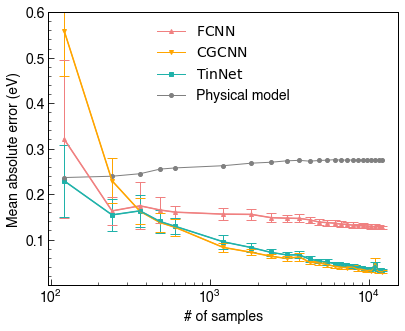

In [9]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax = plt.subplots()

ax.plot(x_axis,
           learning_curve_fcnn[:,0],
           color = 'lightcoral',
           linewidth = 1,
           label=r'$\rm FCNN$',
           marker = '^',
           markersize=4)

ax.plot(x_axis,
           learning_curve_gcnn[:,0],
           color = 'orange',
           linewidth = 1,
           label=r'$\rm CGCNN$',
           marker = 'v',
           markersize=4)

ax.plot(x_axis,
           learning_curve_tinnet_4[:,0],
           color = 'lightseagreen',
           linewidth = 1,
           label=r'$\rm TinNet$',
           marker = 's',
           markersize=4)

ax.plot(x_axis,
           learning_curve_tb[:,0],
           color = 'gray',
           linewidth = 1,
           label= 'Physical model',
           marker = 'o',
           markersize=4)

ax.errorbar(x_axis, learning_curve_fcnn[:,0], yerr=learning_curve_fcnn[:,1], color='lightcoral',capsize = 5,elinewidth=1)
ax.errorbar(x_axis, learning_curve_gcnn[:,0], yerr=learning_curve_gcnn[:,1], color='orange',capsize = 5,elinewidth=1)
ax.errorbar(x_axis, learning_curve_tinnet_4[:,0], yerr=learning_curve_tinnet_4[:,1], color='lightseagreen',capsize = 5,elinewidth=1)

ax.set_ylim([0, 0.60])


plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

ax.legend(loc='upper center',frameon = False)

ax.set_xscale('log')

ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])

ax.set_xlabel('# of samples')
ax.set_ylabel('Mean absolute error (eV)')
#plt.savefig('../../Learning_curve.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

### Make Figure 3b

Load related data of parity plot, specifically, the mean and standard deviation of TinNet-prediction values based on cross validations.

In [10]:
tinnet_4_100_avg = np.loadtxt('Data/tinnet_4_1.00_avg.txt')
tinnet_4_100_std = np.loadtxt('Data/tinnet_4_1.00_std.txt')

Make the parity plot between DFT-calculated and TinNet-predicted d-band center

No handles with labels found to put in legend.


([<matplotlib.axis.YTick at 0x1408af390>,
 <a list of 6 Text yticklabel objects>)

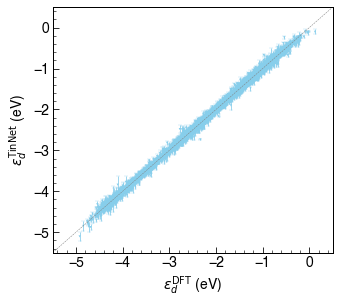

In [11]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.0*1.5*1.67323,1.8*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax = plt.subplots()

X = tinnet_4_100_avg[:,1]
y = tinnet_4_100_avg[:,2]

ax.scatter(X,
           y,
           marker = 'v',
           edgecolor = 'None',
           facecolors='skyblue',
           linewidth = 0.5,
           label = '',
           s = 5)

ax.errorbar(X, y, yerr=tinnet_4_100_std[:,2], color='skyblue', linestyle='', linewidth = 0.8, capthick=0.3, capsize=2, zorder=-32, alpha=1.0)



plt.plot([-5.5,0.5], [-5.5,.5], color='gray', linestyle='--', linewidth=0.5)

plt.legend(frameon=False)

ax.set_xlabel(r'$\epsilon_{d}^{\rm DFT}$ (eV)')
ax.set_ylabel(r'$\epsilon_{d}^{\rm TinNet}$ (eV)')

plt.xlim([-5.5,0.5])
plt.ylim([-5.5,0.5])

plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.xticks([-5,-4,-3,-2,-1,0])
plt.yticks([-5,-4,-3,-2,-1,0])


#fig.savefig('../../parity.PNG', bbox_inches='tight',dpi=600)


Visualize the distribution of the DFT-calculated d-band center 

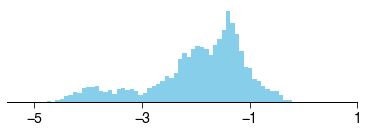

In [12]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,0.7*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()


plt.hist(X,80,(-5.5,1),alpha = 1,color='skyblue',density=True)

mu, std = norm.fit(X)
x = np.linspace(-5.5, 1, 50)
p = norm.pdf(x, mu, std)
#plt.plot(x, p, '--' 'k', linewidth=1)

plt.xlim([-5.5,1])

plt.tick_params(axis="y",direction="out",which='both')
plt.tick_params(axis="x",direction="out",which='both')
plt.xticks([-5,-3,-1,1])
#plt.xticks([])
plt.yticks([])

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

#ax1.set_xlabel(r'$\epsilon_{d}^{\rm DFT}$ (eV)')

#plt.savefig('../../parity_histogram.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

Visualize the prediction error distribution

([], <a list of 0 Text yticklabel objects>)

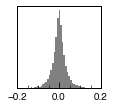

In [13]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 0.6*1.5*1.67323,0.6*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=5*2.0)

fig, ax1 = plt.subplots()


plt.hist(X-y,200,alpha = 1,color='gray',density=True)
mu, std = norm.fit(X-y)
x = np.linspace(-0.2, 0.2, 500)
p = norm.pdf(x, mu, std)
#plt.plot(x, p, '--' 'k', linewidth=1)
plt.xlim([-0.2,0.2])
plt.minorticks_on()
#plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.yticks([])

#plt.savefig('../../parity_histogram_error.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

### Make Figure 4a

Plot the distribution of all the physical parameters predicted by TinNet, with the same bin size or density.

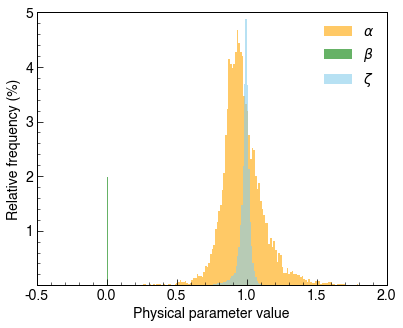

In [14]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


plt.hist(alpha/(12**0.5),150,alpha = 0.6,color='orange',weights=np.ones_like(beta)/len(relax_images)*100,label=r'$\alpha$')
plt.hist(beta,19,alpha = 0.6,color='green',weights=np.ones_like(beta)/len(relax_images)*100*0.02,label=r'$\beta$')
plt.hist(zeta.ravel(),44,alpha = 0.6,color='skyblue',weights=np.ones_like(zeta.ravel())/len(zeta.ravel())*100*0.25,label=r'$\zeta$')
plt.xlim([-0.5,2])
plt.ylim([0,5])
plt.xticks([-0.5,0,0.5,1,1.5,2])
plt.yticks([1,2,3,4,5])
plt.ylabel('Relative frequency (%)')
plt.xlabel('Physical parameter value')
plt.legend(frameon=False)

ax1.minorticks_on()

ax1.tick_params(axis="x",direction="in",which='both')
ax1.tick_params(axis="y",direction="in",which='both')

#plt.savefig('physical_paramters_frequency.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

Make a separate histogram for $\beta$ to show its distribution details

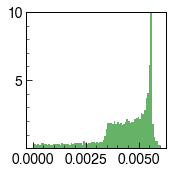

In [15]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 1*1.5*1.67323,1*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

plt.hist(beta,80,(0,0.006),alpha = 0.6,color='green',weights=np.ones_like(beta)/len(relax_images)*100,label=r'$\beta$')

plt.ylim([0,10])
plt.yticks([5.0,10])

ax1.minorticks_on()
ax1.tick_params(axis="x",direction="in",which='both')
ax1.tick_params(axis="y",direction="in",which='both')

#plt.savefig('physical_paramters_frequency_beta.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

### Make Figure 4b

For SHAP analysis in this work, we use the pure metal surface with the same element and facet as the base to compare with, so we need to group the dataset based on the facet, i.e. FCC111 and FCC100 (The main two components of the dataset and occupy over 92% of the overall data points. Some pure surfaces in FCC211 are not converged in DFT-calculations, so we do not use FCC211 for SHAP analysis)

In [67]:
#Locate all FCC111 structures, perform SHAP analsysis and save the Shapley value of each parameter


base_facet = '111'
number_nbr = 12

base_facet_idx = []
for i in range(len(relax_images)):
    if tabulated_name[i][:3]==base_facet:
        base_facet_idx.append(i)
base_facet_nbr_element = []
for idx in base_facet_idx:
    base_facet_nbr_element.append([unrelax_images[idx][j].symbol for j in tabulated_nbr_index_sorted[idx].astype(int)])
base_facet_rd_nbr = np.array([[reference_data[base_facet_nbr_element[i][j]]['rd'] for j in range(number_nbr)] for i in range(len(base_facet_idx))])

selected_delta_cen = []

selected_rdj = []
selected_dij = []
selected_zeta = []
selected_beta = []
selected_alpha = []
selected_mulliken = []

selected_idx = base_facet_idx

for kk in range(len(selected_idx)):
    
    idx = selected_idx[kk]   
    base_element = tabulated_site_element[idx]
    ref_ratio = reference_data[base_element]['d_cen']/reference_data[base_element]['Wd']
    base_idx = np.where(tabulated_name==base_facet+'_'+base_element+'_1.000')[0][0]
    test_idx = np.int64(selected_idx[kk])
    
    selected_delta_cen.append(tinnet_d_cen[test_idx] - tinnet_d_cen[base_idx])

    base_inner_idx = np.where(base_facet_idx==base_idx)[0][0]
    test_inner_idx = np.where(base_facet_idx==test_idx)[0][0]
    base_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        base_X_W[0][3*i+0]=base_facet_rd_nbr[base_inner_idx][i]
        base_X_W[0][3*i+1]=tabulated_d_ij_sorted[base_idx][i]
        base_X_W[0][3*i+2]=zeta[base_idx][i]
    base_X_W[0][-3] = alpha[base_idx]
    base_X_W[0][-2] = beta[base_idx]
    base_X_W[0][-1] = tabulated_mulliken[base_idx]

    test_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        test_X_W[0][3*i+0]=base_facet_rd_nbr[test_inner_idx][i]
        test_X_W[0][3*i+1]=tabulated_d_ij_sorted[test_idx][i]
        test_X_W[0][3*i+2]=zeta[test_idx][i]
    test_X_W[0][-3] = alpha[test_idx]
    test_X_W[0][-2] = beta[test_idx]
    test_X_W[0][-1] = tabulated_mulliken[test_idx]

    explainer = shap.Explainer(d_center, base_X_W)
    shap_values = explainer(test_X_W)
    
    rdj_ = 0
    dij_ = 0
    zeta_ = 0

    alpha_ = shap_values.values[0][-3]
    beta_ = shap_values.values[0][-2]
    mulliken_ = shap_values.values[0][-1]

    selected_alpha.append(alpha_)
    selected_beta.append(beta_)
    selected_mulliken.append(mulliken_)
    
    for i in range(number_nbr):
        rdj_ += shap_values.values[0][3*i+0]
        dij_ += shap_values.values[0][3*i+1]
        zeta_ += shap_values.values[0][3*i+2]

    selected_rdj.append(rdj_)
    selected_dij.append(dij_)
    selected_zeta.append(zeta_)

FCC111_SHAP_dic = {'delt_cen':selected_delta_cen,'rdj':selected_rdj, 'dij':selected_dij, 'alpha':selected_alpha, 'mulliken':selected_mulliken, 'beta':selected_beta, 'zeta':selected_zeta}
FCC111_SHAP_df = pd.DataFrame(FCC111_SHAP_dic)
FCC111_SHAP_df.to_csv('FCC111_SHAP.csv')

In [69]:
#Locate all FCC100 structures, perform SHAP analsysis and save the Shapley value of each parameter

base_facet = '100'
number_nbr = 12

base_facet_idx = []
for i in range(len(relax_images)):
    if tabulated_name[i][:3]==base_facet:
        base_facet_idx.append(i)
base_facet_nbr_element = []
for idx in base_facet_idx:
    base_facet_nbr_element.append([unrelax_images[idx][j].symbol for j in tabulated_nbr_index_sorted[idx].astype(int)])
base_facet_rd_nbr = np.array([[reference_data[base_facet_nbr_element[i][j]]['rd'] for j in range(number_nbr)] for i in range(len(base_facet_idx))])

selected_delta_cen = []

selected_rdj = []
selected_dij = []
selected_zeta = []
selected_beta = []
selected_alpha = []
selected_mulliken = []

selected_idx = base_facet_idx

for kk in range(len(selected_idx)):
    
    idx = selected_idx[kk]   
    base_element = tabulated_site_element[idx]
    ref_ratio = reference_data[base_element]['d_cen']/reference_data[base_element]['Wd']
    base_idx = np.where(tabulated_name==base_facet+'_'+base_element+'_1.000')[0][0]
    test_idx = np.int64(selected_idx[kk])
    
    selected_delta_cen.append(tinnet_d_cen[test_idx] - tinnet_d_cen[base_idx])

    base_inner_idx = np.where(base_facet_idx==base_idx)[0][0]
    test_inner_idx = np.where(base_facet_idx==test_idx)[0][0]
    base_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        base_X_W[0][3*i+0]=base_facet_rd_nbr[base_inner_idx][i]
        base_X_W[0][3*i+1]=tabulated_d_ij_sorted[base_idx][i]
        base_X_W[0][3*i+2]=zeta[base_idx][i]
    base_X_W[0][-3] = alpha[base_idx]
    base_X_W[0][-2] = beta[base_idx]
    base_X_W[0][-1] = tabulated_mulliken[base_idx]

    test_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        test_X_W[0][3*i+0]=base_facet_rd_nbr[test_inner_idx][i]
        test_X_W[0][3*i+1]=tabulated_d_ij_sorted[test_idx][i]
        test_X_W[0][3*i+2]=zeta[test_idx][i]
    test_X_W[0][-3] = alpha[test_idx]
    test_X_W[0][-2] = beta[test_idx]
    test_X_W[0][-1] = tabulated_mulliken[test_idx]

    explainer = shap.Explainer(d_center, base_X_W)
    shap_values = explainer(test_X_W)
    
    rdj_ = 0
    dij_ = 0
    zeta_ = 0

    alpha_ = shap_values.values[0][-3]
    beta_ = shap_values.values[0][-2]
    mulliken_ = shap_values.values[0][-1]

    selected_alpha.append(alpha_)
    selected_beta.append(beta_)
    selected_mulliken.append(mulliken_)
    
    for i in range(number_nbr):
        rdj_ += shap_values.values[0][3*i+0]
        dij_ += shap_values.values[0][3*i+1]
        zeta_ += shap_values.values[0][3*i+2]

    selected_rdj.append(rdj_)
    selected_dij.append(dij_)
    selected_zeta.append(zeta_)


FCC100_SHAP_dic = {'delt_cen':selected_delta_cen,'rdj':selected_rdj, 'dij':selected_dij, 'alpha':selected_alpha, 'mulliken':selected_mulliken, 'beta':selected_beta, 'zeta':selected_zeta}
FCC100_SHAP_df = pd.DataFrame(FCC111_SHAP_dic)
FCC100_SHAP_df.to_csv('FCC100_SHAP.csv')

Plot distribution of Shapley values of all the physical parameters

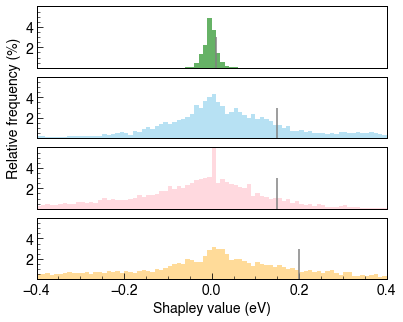

In [84]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

plt.subplots_adjust(wspace=0, hspace=0.15)


bbin = 400
xll = -2
xhh = 2

xl = -0.4
xh = 0.4
yh = 6

data_length = len(FCC111_SHAP_df['beta']) + len(FCC100_SHAP_df['beta'])
length_array = np.array(list(range(data_length)))

weig = np.ones_like(length_array)/len(length_array)*100

plt.subplot(4,1,1)
plt.hist(np.array(list(FCC111_SHAP_df['beta'])+list(FCC100_SHAP_df['beta']))+np.array(list(FCC111_SHAP_df['mulliken'])+list(FCC100_SHAP_df['mulliken'])),bbin,(xll,xhh),alpha = 0.6,color='green',weights=weig*0.15,label='electron transfer')
plt.xlim([xl,xh])
plt.ylim([0,yh])
plt.xticks([])
plt.yticks([2,4])
plt.vlines(0.01,ymin=0,ymax=3,colors='gray',linestyles='-',linewidth=1.5)
plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.subplot(4,1,2)
plt.hist(np.array(list(FCC111_SHAP_df['dij'])+list(FCC100_SHAP_df['dij']))+np.array(list(FCC111_SHAP_df['zeta'])+list(FCC100_SHAP_df['zeta'])),bbin,(xll,xhh),alpha = 0.6,color='skyblue',weights=weig,label='strain effect')
plt.xlim([xl,xh])
plt.ylim([0,yh])
plt.xticks([])
plt.yticks([2,4])
plt.vlines(0.15,ymin=0,ymax=3,colors='gray',linestyles='-',linewidth=1.5)
plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')
plt.ylabel('Relative frequency (%)')

plt.subplot(4,1,3)
plt.hist(np.array(list(FCC111_SHAP_df['rdj'])+list(FCC100_SHAP_df['rdj'])),bbin,(xll,xhh),alpha = 0.6,color='pink',weights=weig,label='ligand')
plt.xlim([xl,xh])
plt.ylim([0,yh])
plt.xticks([])
plt.yticks([2,4])
plt.vlines(0.15,ymin=0,ymax=3,colors='gray',linestyles='-',linewidth=1.5)
plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.subplot(4,1,4)
plt.hist(np.array(list(FCC111_SHAP_df['alpha'])+list(FCC100_SHAP_df['alpha'])),bbin,(xll,xhh),alpha = 0.4,color='orange',weights=weig,label='resonance effect')
plt.xlim([xl,xh])
plt.ylim([0,yh])
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.yticks([2,4])
plt.vlines(0.20,ymin=0,ymax=3,colors='gray',linestyles='-',linewidth=1.5)
plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')
plt.xlabel('Shapley value (eV)')

#plt.savefig('merge_abs_shap_global_SHAP_frequency.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

Calculate the mean of absoluate Shapley value of each effect

In [73]:
miu_resonance = abs(np.array(list(FCC111_SHAP_df['alpha'])+list(FCC100_SHAP_df['alpha']))).mean()
miu_ligand = abs(np.array(list(FCC111_SHAP_df['rdj'])+list(FCC100_SHAP_df['rdj']))).mean()
miu_strain = abs(np.array(list(FCC111_SHAP_df['zeta'])+list(FCC100_SHAP_df['zeta']))+np.array(list(FCC111_SHAP_df['dij'])+list(FCC100_SHAP_df['dij']))).mean()
miu_electron_transfer = abs(np.array(list(FCC111_SHAP_df['beta'])+list(FCC100_SHAP_df['beta']))+np.array(list(FCC111_SHAP_df['mulliken'])+list(FCC100_SHAP_df['mulliken']))).mean()

print(miu_electron_transfer)
print(miu_strain)
print(miu_ligand)
print(miu_resonance)

0.011104837069698323
0.15477776321191192
0.15384268781302668
0.20061138306326806


### Make Figure 5

Locate all the Pt-on-M monolayer structures

In [16]:
dij_element_sort = ['Co', 'Ni', 'Cu', 'Os', 'Ru', 'Rh', 'Re', 'Ir', 'Pd', 'Au', 'Ag']
ML_idx = np.array([np.where(tabulated_name == '111_M-Pt_'+ele)[0][0] for ele in dij_element_sort])

Calculate all the Shapley values

In [17]:
base_facet = '111'
number_nbr = 12

base_facet_idx = []
for i in range(len(relax_images)):
    if tabulated_name[i][:3]==base_facet:
        base_facet_idx.append(i)
base_facet_nbr_element = []
for idx in base_facet_idx:
    base_facet_nbr_element.append([unrelax_images[idx][j].symbol for j in tabulated_nbr_index_sorted[idx].astype(int)])
base_facet_rd_nbr = np.array([[reference_data[base_facet_nbr_element[i][j]]['rd'] for j in range(number_nbr)] for i in range(len(base_facet_idx))])


base_element = 'Pt'

ref_ratio = reference_data[base_element]['d_cen']/reference_data[base_element]['Wd']
base_idx = np.where(tabulated_name==base_facet+'_'+base_element+'_1.000')[0][0]

ele_1 = base_element

selected_delta_cen = []
selected_images = []

selected_rdj = []
selected_dij = []
selected_zeta = []
selected_beta = []
selected_alpha = []
selected_mulliken = []
selected_concen = []

selected_idx = ML_idx

for kk in range(len(selected_idx)):
    
    idx = selected_idx[kk]
    
    selected_images.append(unrelax_images[idx])
    
    base_element = tabulated_site_element[idx]
    ref_ratio = reference_data[base_element]['d_cen']/reference_data[base_element]['Wd']
    base_idx = np.where(tabulated_name==base_facet+'_'+base_element+'_1.000')[0][0]
    test_idx = np.int64(selected_idx[kk])
    
    selected_delta_cen.append(tinnet_d_cen[test_idx] - tinnet_d_cen[base_idx])

    base_inner_idx = np.where(base_facet_idx==base_idx)[0][0]
    test_inner_idx = np.where(base_facet_idx==test_idx)[0][0]
    base_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        base_X_W[0][3*i+0]=base_facet_rd_nbr[base_inner_idx][i]
        base_X_W[0][3*i+1]=tabulated_d_ij_sorted[base_idx][i]
        base_X_W[0][3*i+2]=zeta[base_idx][i]
    base_X_W[0][-3] = alpha[base_idx]
    base_X_W[0][-2] = beta[base_idx]
    base_X_W[0][-1] = tabulated_mulliken[base_idx]

    test_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        test_X_W[0][3*i+0]=base_facet_rd_nbr[test_inner_idx][i]
        test_X_W[0][3*i+1]=tabulated_d_ij_sorted[test_idx][i]
        test_X_W[0][3*i+2]=zeta[test_idx][i]
    test_X_W[0][-3] = alpha[test_idx]
    test_X_W[0][-2] = beta[test_idx]
    test_X_W[0][-1] = tabulated_mulliken[test_idx]

    explainer = shap.Explainer(d_center, base_X_W)
    shap_values = explainer(test_X_W)
    
    rdj_ = 0
    dij_ = 0
    zeta_ = 0

    alpha_ = shap_values.values[0][-3]
    beta_ = shap_values.values[0][-2]
    mulliken_ = shap_values.values[0][-1]

    selected_alpha.append(alpha_)
    selected_beta.append(beta_)
    selected_mulliken.append(mulliken_)
    
    for i in range(number_nbr):
        rdj_ += shap_values.values[0][3*i+0]
        dij_ += shap_values.values[0][3*i+1]
        zeta_ += shap_values.values[0][3*i+2]

    selected_rdj.append(rdj_)
    selected_dij.append(dij_)
    selected_zeta.append(zeta_)

For electron transfer effect, plot the correlation between its Shapley value and electronegativity difference, and calculate the correlation coefficient R.

No handles with labels found to put in legend.


R = -0.9464473610435723


(-0.045, 0.01)

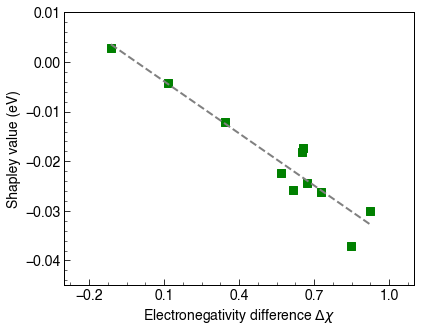

In [18]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

X = tabulated_mulliken[selected_idx]
y = np.array(selected_mulliken)+np.array(selected_beta)

ax1.scatter(X,y,color='green',marker='s',s=50)

ax1.minorticks_on()

ax1.tick_params(axis="x",direction="in",which='both',)
ax1.tick_params(axis="y",direction="in",which='both')

ax1.set_xticks([-0.2,0.1,0.4,0.7,1.0])
ax1.set_yticks([-0.04,-0.03,-0.02,-0.01,0,0.01])

ax1.set_xlabel(r'Electronegativity difference $\Delta \chi$')
ax1.set_ylabel('Shapley value (eV)')
ax1.legend(loc='upper left',frameon=False)

Z = np.polyfit(X,y,1)
plt.plot(np.sort(X),(Z[0]*np.array(X)+Z[1])[np.argsort(X)],'--',color='gray',linewidth=2)
corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
print('R = '+str(corr))

plt.xlim([-0.3,1.1])
plt.ylim([-0.045,0.01])

#plt.savefig('trend_ele_transf.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

For strain effect, plot the correlation between its Shapley value and lattice constant, and calculate the correlation coefficient R.

No handles with labels found to put in legend.


R = 0.986416203007424


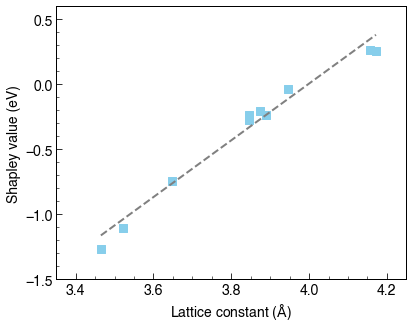

In [19]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

X = np.array([reference_data[ele]['dij'] for ele in dij_element_sort])*2**0.5
y = np.array(selected_dij) + np.array(selected_zeta)

ax1.scatter(X,y,color='skyblue',marker='s',s=50)

ax1.minorticks_on()

ax1.tick_params(axis="x",direction="in",which='both',)
ax1.tick_params(axis="y",direction="in",which='both')



ax1.set_xlabel(r'Lattice constant ($\rm \AA$)')
ax1.set_ylabel('Shapley value (eV)')
ax1.legend(loc='upper left',frameon=False)

Z = np.polyfit(X,y,1)
plt.plot(np.sort(X),(Z[0]*np.array(X)+Z[1])[np.argsort(X)],'--',color='gray',linewidth=2)

ax1.set_xticks([3.4,3.6, 3.8,4,4.2])
ax1.set_yticks([-1.50,-1.00, -0.50, 0,0.5])

plt.xlim([3.35,4.25])
plt.ylim([-1.5,0.6])

corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
print('R = '+str(corr))

#plt.savefig('trend_strain.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

For ligand effect, plot the correlation between its Shapley value and d-orbital radius of the substrate metal, and calculate the correlation coefficient R.

No handles with labels found to put in legend.


R = -0.9891852211567385


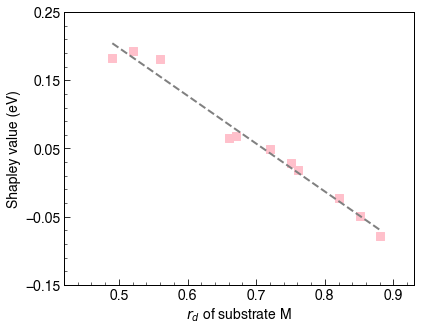

In [21]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

X = [reference_data[ele]['rd'] for ele in dij_element_sort]
y = selected_rdj

ax1.scatter(X,y,color='pink',marker='s',s=50)

ax1.minorticks_on()

ax1.tick_params(axis="x",direction="in",which='both',)
ax1.tick_params(axis="y",direction="in",which='both')

ax1.set_xticks([0.5,0.6,0.7,0.8,0.9])
ax1.set_yticks([-0.15,-0.05,0.05,0.15,0.25])
plt.xlim([0.42,0.93])
plt.ylim([-0.15,0.25])

ax1.set_xlabel(r'$r_d$ of substrate M')
ax1.set_ylabel('Shapley value (eV)')
ax1.legend(loc='upper left',frameon=False)

Z = np.polyfit(X,y,1)
plt.plot(np.sort(X),(Z[0]*np.array(X)+Z[1])[np.argsort(X)],'--',color='gray',linewidth=2)
corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
print('R = '+str(corr))

#plt.savefig('trend_ligand.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

For resonance effect, plot the correlation between its Shapley value and d-level misalignment between substrate metal and Pt, and calculate the correlation coefficient R.

No handles with labels found to put in legend.


R = -0.8294776008329389


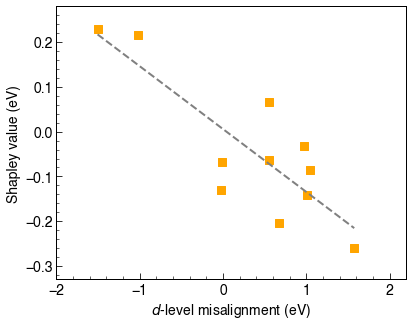

In [22]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

X = np.array([reference_data[ele]['d_cen'] for ele in dij_element_sort]) - reference_data['Pt']['d_cen']
y = selected_alpha

ax1.scatter(X,y,color='orange',marker='s',s=50)

ax1.minorticks_on()

ax1.tick_params(axis="x",direction="in",which='both',)
ax1.tick_params(axis="y",direction="in",which='both')

ax1.set_xlabel(r'$d$-level misalignment (eV)')
ax1.set_ylabel('Shapley value (eV)')
ax1.legend(loc='upper left',frameon=False)

ax1.set_xticks([-2,-1,0,1,2])
ax1.set_yticks([-0.3,-0.2,-0.1,0,0.1,0.2])
plt.xlim([-2,2.2])
plt.ylim([-0.33,0.28])

Z = np.polyfit(X,y,1)
plt.plot(np.sort(X),(Z[0]*np.array(X)+Z[1])[np.argsort(X)],'--',color='gray',linewidth=2)
corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
print('R = '+str(corr))

#plt.savefig('trend_resonance.png', format='png',transparent = True,dpi=600, bbox_inches='tight')

### Make Figure 6a

Load DOS data fot Pt and Pt1Au SAA

In [36]:
energ = np.linspace(-15,15,3001)
dos_Pt = np.loadtxt('Data/dos_Pt.txt')
dos_SAA = np.loadtxt('Data/dos_Pt1Au.txt')

Plot DOS

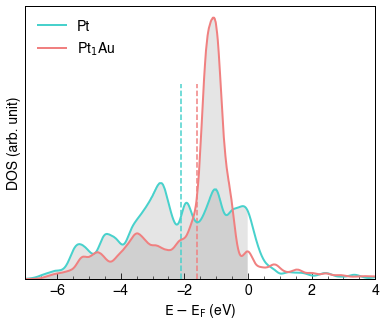

In [37]:
# the id for Pt1Au SAA is 8880

Pt1Au_idx = 8880

symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

plt.plot(energ,dos_Pt,color='mediumturquoise', linewidth = 2,label = 'Pt',alpha=1)
plt.plot(energ,dos_SAA,color='lightcoral', linewidth = 2,label = r'Pt$_1$Au',alpha=1)
plt.xlabel(r'$\rm E - E_F$ (eV)')
plt.ylabel('DOS (arb. unit)')
plt.minorticks_on()
#plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')
plt.legend(ncol=1,loc = 'upper left',frameon=False)
plt.xlim([-7,4])
plt.ylim([0,0.7])
plt.xticks([-6,-4,-2,0,2,4])
plt.yticks([])

plt.fill_between(energ,0,dos_Pt,where = energ<0,color='gray',alpha=0.2,linewidth=0.0)
plt.fill_between(energ,0,dos_SAA,where = energ<0,color='gray',alpha=0.2,linewidth=0.0)

plt.vlines(dft_d_cen[base_idx],ymin=0,ymax=0.5,colors='mediumturquoise',linestyles='--',linewidth=1.5)
plt.vlines(dft_d_cen[Pt1Au_idx],ymin=0,ymax=0.5,colors='lightcoral',linestyles='--',linewidth=1.5)

#plt.savefig('PtAu_SAA_dos.png', format='png',transparent = True,dpi=600,bbox_inches='tight')

### Make Figure 6b

Calculate Shapley values of Pt1Au SAA with pure Pt as the base

In [38]:
selected_delta_cen = []
selected_images = []

selected_rdj = []
selected_dij = []
selected_zeta = []
selected_beta = []
selected_alpha = []
selected_mulliken = []
selected_concen = []

selected_idx = [Pt1Au_idx]

for kk in range(len(selected_idx)):
    
    idx = selected_idx[kk]
    
    selected_images.append(unrelax_images[idx])
    
    base_element = tabulated_site_element[idx]
    ref_ratio = reference_data[base_element]['d_cen']/reference_data[base_element]['Wd']
    base_idx = np.where(tabulated_name==base_facet+'_'+base_element+'_1.000')[0][0]
    test_idx = np.int64(selected_idx[kk])
    
    selected_delta_cen.append(tinnet_d_cen[test_idx] - tinnet_d_cen[base_idx])

    base_inner_idx = np.where(base_facet_idx==base_idx)[0][0]
    test_inner_idx = np.where(base_facet_idx==test_idx)[0][0]
    base_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        base_X_W[0][3*i+0]=base_facet_rd_nbr[base_inner_idx][i]
        base_X_W[0][3*i+1]=tabulated_d_ij_sorted[base_idx][i]
        base_X_W[0][3*i+2]=zeta[base_idx][i]
    base_X_W[0][-3] = alpha[base_idx]
    base_X_W[0][-2] = beta[base_idx]
    base_X_W[0][-1] = tabulated_mulliken[base_idx]

    test_X_W = np.array([[0.0]*(number_nbr*3+3)])
    for i in range(number_nbr):
        test_X_W[0][3*i+0]=base_facet_rd_nbr[test_inner_idx][i]
        test_X_W[0][3*i+1]=tabulated_d_ij_sorted[test_idx][i]
        test_X_W[0][3*i+2]=zeta[test_idx][i]
    test_X_W[0][-3] = alpha[test_idx]
    test_X_W[0][-2] = beta[test_idx]
    test_X_W[0][-1] = tabulated_mulliken[test_idx]

    explainer = shap.Explainer(d_center, base_X_W)
    shap_values = explainer(test_X_W)
    
    rdj_ = 0
    dij_ = 0
    zeta_ = 0

    alpha_ = shap_values.values[0][-3]
    beta_ = shap_values.values[0][-2]
    mulliken_ = shap_values.values[0][-1]

    selected_alpha.append(alpha_)
    selected_beta.append(beta_)
    selected_mulliken.append(mulliken_)
  
    for i in range(number_nbr):
        rdj_ += shap_values.values[0][3*i+0]
        dij_ += shap_values.values[0][3*i+1]
        zeta_ += shap_values.values[0][3*i+2]

    selected_rdj.append(rdj_)
    selected_dij.append(dij_)
    selected_zeta.append(zeta_)

Plot the waterfall chart. Note that the one in the main text has been refined using Adobe Illustrator.

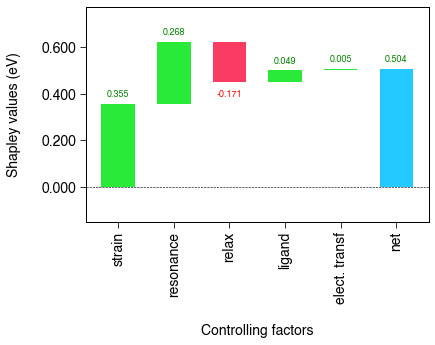

In [39]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 2.5*1.5*1.67323,2.0*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

a = ['ligand','resonance','strain','relax','elect. transf']
b = [selected_rdj[0],selected_alpha[0],selected_dij[0],selected_zeta[0],selected_beta[0]+selected_mulliken[0]]
my_plot = waterfall_chart.plot(a, b, sorted_value=True,formatting='{:,.3f}',rotation_value=90,x_lab = 'Controlling factors',y_lab = 'Shapley values (eV)')
#my_plot.savefig('PtAu_SAA_SHAP_effects.png', format='png',transparent = True,dpi=600,bbox_inches='tight')